# Lesson 1 Pratice Notebook
This notebook contains pratice code generated while going through Lesson 1 of FastAI course.
### Intro the dataset
* The Dog vs Cats dataset consists of lebelled imaged of dogs and cats.
* Total number of training examples, $m_{train}$ = 25,000
* Total number of test examples, $m_{test}$ = 12,5000.
* As of 2013, best performing machine learning algorithms had about 80% accuracy.

In order to get set up, let's configure this notebook. This will make sure that external modules are automatically reloaded if any changes are made to the underlying code, and that plotting and fastai functionality is available to us.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

In [3]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

Let's also make sure that NVidia GPU is set up and ready to use.

In [4]:
print(torch.cuda.is_available())
# this is optional
print(torch.backends.cudnn.enabled)

True
True


Perfect! Finally, let's set some global variables, such as the path to the dataset files and the image size (more details on this later). 

In [5]:
PATH = "data/dogscats/"
sz = 224

### A note on dataset organization for ML/DL
One of the major takeaways from this lesson was that typically the datasets for ML/DL are split as follows:

* Train: This is our training dataset.

* Valid: This is validation dataset, used for hyperparamter optimization.

* Test: This the final test set unseen by the model.

One can also create a parallel version of the above for just setting things up, just to make sure that everything is working fine. We can call this sample dataset.

## A quick look at the dataset
Let's take a look at the dataset and also see if our directory structure is organized properly.

In [6]:
os.listdir(PATH)

['sample', 'valid', 'models', 'train', 'tmp', 'test1']

In [7]:
os.listdir(f'{PATH}valid')

['cats', 'dogs']

In [8]:
files = os.listdir(f'{PATH}valid/cats')
files[:10]

['cat.11341.jpg',
 'cat.3869.jpg',
 'cat.5089.jpg',
 'cat.7380.jpg',
 'cat.11409.jpg',
 'cat.7585.jpg',
 'cat.3808.jpg',
 'cat.3052.jpg',
 'cat.1616.jpg',
 'cat.7850.jpg']

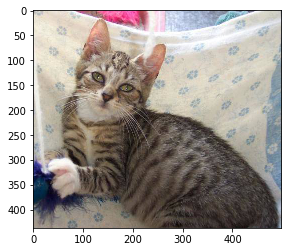

In [9]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

In [10]:
img.shape

(437, 499, 3)

In [11]:
img[:4, :4]

array([[[211, 211, 219],
        [210, 211, 216],
        [208, 207, 213],
        [202, 201, 206]],

       [[200, 201, 206],
        [199, 198, 204],
        [196, 195, 200],
        [193, 192, 197]],

       [[193, 192, 197],
        [189, 188, 193],
        [184, 183, 188],
        [185, 185, 187]],

       [[197, 195, 198],
        [189, 187, 190],
        [181, 179, 180],
        [183, 181, 182]]], dtype=uint8)

## First Model
Main features:
* A pre-trained model, trained on ImageNet
* A convolutional neural network, called resnet 34

Let's train!

In [12]:
arch = resnet34
# load in data
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
# create model
learn = ConvLearner.pretrained(arch, data, precompute=True)

**A note on pre-computed activations**
Based on a quick look around on what does it mean to have precomputed activations for your neural network, I think that this has to do with how transfer learning is basically done. We have a model that is already trained, especially a model from a large dataset (such as ImageNet). We then 'freeze' let's say N layers, which means that we no longer wish to train them anymore and would like to keep there parameters as such. We can then output acttivations form the last frozen layer and save them as part of the model. We can then add one or more new layers that are trained on a new dataset.

In [13]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [14]:
data.classes

['cats', 'dogs']

In [15]:
learn.fit(0.01, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.055497   0.028386   0.991699  
    1      0.042432   0.026612   0.989258                     



[0.026611576, 0.9892578125]

Now that the we have fit the model, we can see that it's accuracy (which I assume is based on cross-validation) is ~99%. Let's take a look at some example of predictions. Once we have a trained model, we can do two types of analyses:
* Visual Inspection: Looking at various categories of results is hugely useful. These categories can include; most correct in category x, most incorrect in category x, just random good or bad predictions etc. One useful thing in this lesson is a bunch of handy plotting functions that generate images in different categories, it is always woth having such utility functions ready for own projects.
* Performance metrics: We can get some useful numbers out of the model, which describe its performance. There will be a lot more on this.

In [16]:
log_preds = learn.predict() # by default predict returns log scores
log_preds.shape

(2000, 2)

In [17]:
log_preds[:10]

array([[ -0.00013,  -8.97293],
       [ -0.00142,  -6.55793],
       [ -0.00034,  -7.99363],
       [ -0.00037,  -7.90226],
       [ -0.00013,  -8.96257],
       [ -0.0004 ,  -7.83427],
       [ -0.00007,  -9.54873],
       [ -0.00002, -10.96591],
       [ -0.0037 ,  -5.60202],
       [ -0.00046,  -7.68351]], dtype=float32)

In [18]:
# let's get prediction, expressed as 0 or 1 for if the image is of a cat or a dog respectively. 
preds = np.argmax(log_preds, axis=1) # basically put 0 or 1 in column 1 based on if column 1 entry is bigger or not, respectively.
# let's also convert log values into probabilities
probs = np.exp(log_preds[:, 1])
print(probs[:10])

[0.00013 0.00142 0.00034 0.00037 0.00013 0.0004  0.00007 0.00002 0.00369 0.00046]


In order to facilitate looking at different images from the dataset and corresponding predictions. let's create some utility functions for plotting. 

In [19]:
def rand_by_mask(mask):
    """
    Selects and returns indices of four random examples, where value of mask is True
    
    Parameters
    ==========
    mask : numpy.ndarray
        Boolean array of correct or incorrect predictions
    
    Return
    ======
    choices : numpy.ndarray
        Array of four indices, where value in mask array is True 
    """
    choices  = np.random.choice(np.where(mask)[0], 4, replace=False)
    return choices

def rand_by_correct(masks, is_correct):
    """
    Applies selection mask (is_coorect) to boolean array of correct and incorrect prediction.
    
    Parameters
    ==========
    masks : numpy.ndarray
        Array of boolean masks, corresponding to correct and incorrect predictions
    is_correct : bool
        Random examples with this boolean mask will be picked
    
    Return
    ======
    selected_examples : numpy.ndarray
        Array of indices, where prediction result corresponds to is_correct
    """
    is_correct_array = (masks == is_correct)
    selected_examples = rand_by_mask(is_correct_array)
    return selected_examples

def most_by_mask(mask, mult):
    """
    Return first four members of a sorted array of all indices corresponding to the mask.
    
    Parameters
    ==========
    mask : numpy.ndarray
        Array of booloean masks
    mult : int
        A multiplication factor to scale probabilities for sorting

    Return
    ======
    examples : numpy.ndarray
        First four members of the
    
    """
    idxs = np.where(mask)[0]
    examples = idxs[np.argsort(mult * probs[idxs])[:4]] 
    return examples

def most_by_correct(y, is_correct): 
    """
    """
    mult = -1 if (y==1)==is_correct else 1
    # assign True to indices, where target categories in validation data are the same as y
    masks = ((preds == data.val_y)==is_correct) & (data.val_y == y)
    return most_by_mask(masks, mult)


In [20]:
# Let's generate an array with boolean mask for every example in the training data, where boolean
# corresponds to whether or not a correct prediction was made 
trn_pred_bool_masks = (preds == data.val_y)
# Let's use this array to get examples in different categories
some_correct_predictions = rand_by_correct(trn_pred_bool_masks, True)
some_wrong_predictions = rand_by_correct(trn_pred_bool_masks, False)
most_correct_cats = most_by_correct(0, True)
most_correct_dogs = most_by_correct(1, True)
most_incorrect_cats = most_by_correct(0, False)
most_incorrect_dogs = most_by_correct(1, False)
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]

#plot_val_with_title(rand_by_correct(True), "Correct")

In [21]:
def load_img_id(ds, idx): 
    """
    Genrate numpy array for the images in the dataset
    """
    
    image_arrays = np.array(PIL.Image.open(PATH+ds.fnames[idx]))
    return image_arrays

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
        
        
def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))


Correct


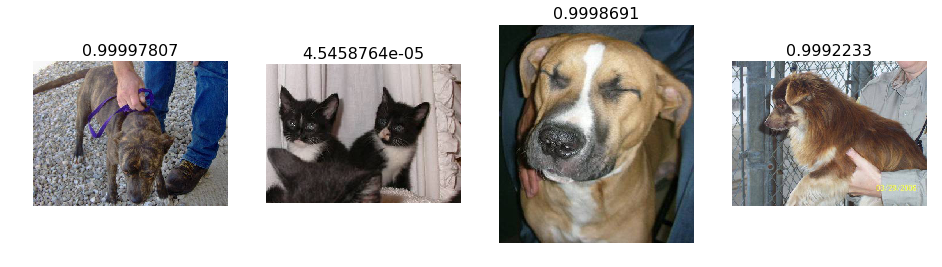

In [22]:
plot_val_with_title(some_correct_predictions, "Correct")

Incorrect


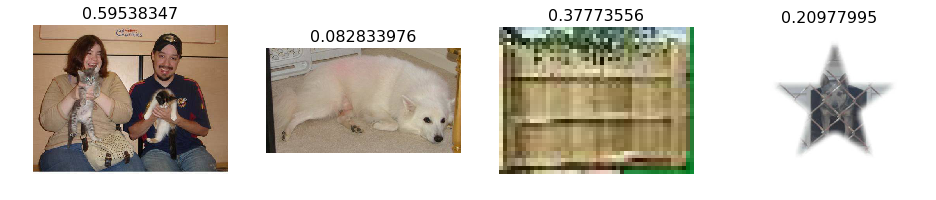

In [23]:
plot_val_with_title(some_wrong_predictions, "Incorrect")

Most correct dogs


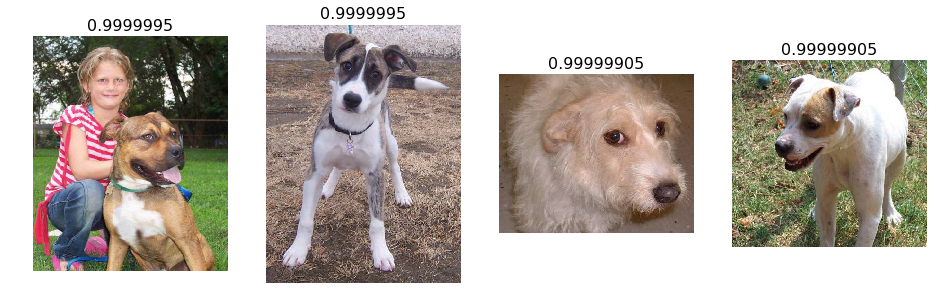

In [24]:
plot_val_with_title(most_correct_dogs, "Most correct dogs")

Most Incorrect dogs


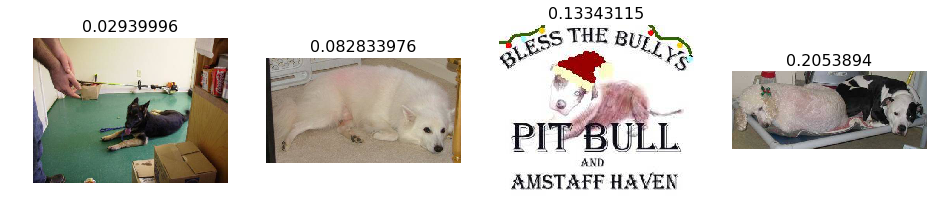

In [25]:
plot_val_with_title(most_incorrect_dogs, "Most Incorrect dogs")

Most correct cats


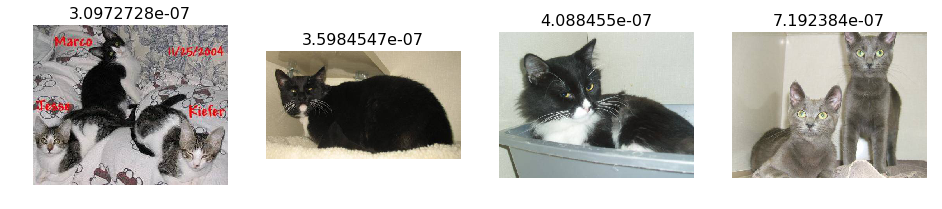

In [26]:
plot_val_with_title(most_correct_cats, "Most correct cats")

Most Incorrect cats


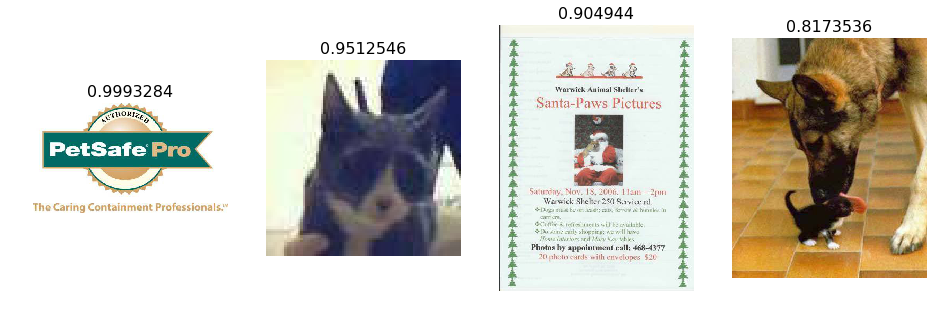

In [27]:
plot_val_with_title(most_incorrect_cats, "Most Incorrect cats")

## Choosing a learning rate
Learning rate is one of the most important hyperparameters to optimize during training. The learning rate will determine how quickly we obtain the minimum loss on the data manifold and how stable this minimum is (i.e., is it a narrow local minimum or a relatively flatter minimum.

In [28]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [29]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 82%|████████▎ | 297/360 [00:04<00:00, 66.99it/s, loss=0.396] 


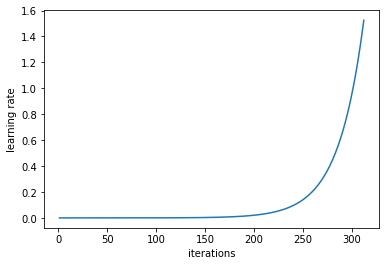

In [30]:
learn.sched.plot_lr()

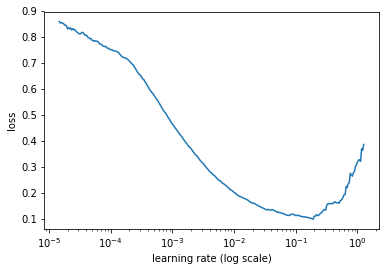

In [31]:
learn.sched.plot()

### The learning schedule
The main idea here is that the learning drops as we get closer and closer to the minimum of the loss function. However,  some sort of a plateau reaches eventually and after this point the loss function will either not change or may even start shooting up. The strategy here is to find the learning rate where loss is still improving but may one one log unit away from from the minimum (1e-2 in this case). 

### Data Augmentation
* A method of generation new training examples that are some transformations of corresponding existing examples in the training data. Example of such transformaions are rotating horizontolly and/or vertically, zooming in/out etc. The fastai's approach towards that is to create a data transformation object that essentially creates a list of functions that transform training examples. We then pass on these functions to our routine data object. Here is how it goes.

In [32]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

This new data object contains training examples that are transformed through `tfms`. Now. we can train the model on this data and we can also bring in our new learning rate vlaue that we decided.

In [33]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(1e-2, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.042003   0.032498   0.990234  



[0.032498293, 0.990234375]

### SGD with Restarts
We don't see much improvement though. We will now bring in the next trick, which is explained below. Let's first set `precompute` to false. This is because we are going to train again with our new trick, the activations from the last layer will get updated as well.

In [34]:
learn.precompute = False

In [35]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.047342   0.023769   0.992188  
    1      0.041215   0.02264    0.992188                     
    2      0.047538   0.025227   0.990234                     



[0.025226908, 0.990234375]

The new trick is Stochastic Gradient Descent with Restarts. The idea here is that every $i^th$ epoch (where $i$ is given by `cycle_len` parameter), we suddenly increase the learning rate. This increase will cause a large update in parameters, which in turn will correspond to a different point on the loss surface. This point may very well be located in the surroundiings of a new minimum, which may be more suitable, especially if it is flatter. The model will generalize better with this trick. This is because we will end up with a region of loss surface that is broader and while the loss is still small, we are in a region on the data manifold, that is likely to contain unseen examples. 
The model performance has gone significantly up now.

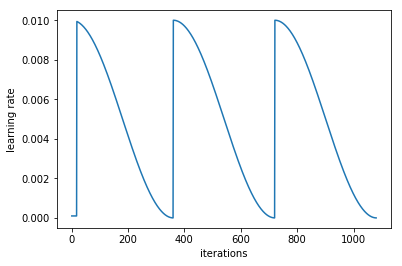

In [36]:
learn.sched.plot_lr()

## More fine-tuning with differential rate learning

Finally, we apply one last trick. Note that whe we create a new instance of a pretrained model (or learner), it by default sets all except the last layer to frozen. In the earlier stages of model building, we do not want all of the layers to get updates. We need the optimized transformations that these layers represent. However, once we have made some headway and are starting to see the model improve, we can unfreeze some of the layers so that their parameters get updated with the new training data. So let's go ahead and unfreez all of the layers.

In [37]:
learn.unfreeze()

However, we are still not really interested in re-doing the learning for early layers (these were trained on millions of examples). One way to keep them unfrozen but not mess them up too much is to set their learning rates to too low. Indeed, we can consider that the netwrok layers to consist of three parts, early, middle and final. Let's now set up learning rates for each of these groups of layers. We will ignore the details of how many layers are in each group.

In [38]:
lr = np.array([1e-4, 1e-3, 1e-2])

In [39]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.055127   0.024481   0.991211  
    1      0.044853   0.018256   0.992188                     
    2      0.028421   0.016953   0.993652                     
    3      0.027127   0.016368   0.995117                     
    4      0.026457   0.015368   0.993652                     
    5      0.026743   0.016199   0.993164                     
    6      0.017538   0.015817   0.993164                     



[0.015817346, 0.9931640625]

This idea is referred to as differential rate learning. The `cycle_mult` parameter needs some comments. First of all, when using SGDR, we are not doing the restart at each epoch to be exact. Indeed, we are doing the restart each cycle. The number of epochs for each cycle are determined by the `cycle_mult` parameter, i.e., if it is 1 then every next cycle will run for one epoch, but if it is 2, then every next cycle will run twice the number of epochs. So 3 cycles with 2 `cycle_mult`, will end have 1, 2, 4 epochs in each cycle respectively. The idea here is that every next restart can be assumed to bring us to a new region of the loss surface. Towards the last cycles, instead of quickly hopping out of the minimum, we actually explore the loss surface for longer time, i.e., we carry out more parameter updates to make sure that we reach the minimum of this new region. This would ensure that subsequent restarts won't just throw us out of this supposedly good place and we will hon in in more and more. 

It is also a good idea to use test-time augmentation on the  validation dataset. The idea is that once the model is trained and we are into using the model on validation dataset, we augment each training example and then we obtained an average prediction based on all augmentations of each example. 

In [42]:
log_preds, y = learn.TTA()
print(log_preds.shape) # Note the change in shape
print(y)

(5, 2000, 2)                                 
[0 0 0 ... 1 1 1]


In [45]:
# To get probabilities from TTA, we have to average
probs = np.mean(np.exp(log_preds), axis=0)
accuracy_np(probs, y)

0.9925

## Analysis of Results
Like most classifiers, we can use confusion matrix to analyze the results. For this we need, true labels and predicted labels. Generating predicted labels in this case involves checking if along the dog category axis, the probability has a higher score or not. If True, and if dog category has been assigned label 1, then we can simply use this array as our predictions of labels. 

In [49]:
from sklearn.metrics import confusion_matrix
preds = np.argmax(probs, axis=1)
print(preds)
probs = probs[:, 1]
print(probs)

[0 0 0 ... 1 1 1]
[0.      0.00093 0.00025 ... 0.99995 0.99995 0.99933]


[[993   7]
 [  8 992]]


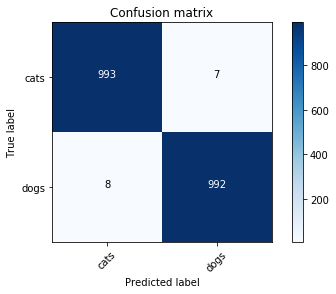

In [50]:
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)

Let's save the model before we leave

In [51]:
learn.save('224_all')